In [114]:
import numpy as np
import matplotlib.pyplot as plt
import time

# 1.

In [61]:
def xy_a_s(x, y, L):
    return y * L + x

def s_a_xy(s, L):
    return s % L, s // L

def vecino(s, j, L, empty):
    if j == 0:  
        if s % L == L - 1:
            return empty
        else:
            return s + 1
    elif j == 1:  
        if s // L == L - 1:
            return empty
        else:
            return s + L
    elif j == 2:  
        if s % L == 0:
            return empty
        else:
            return s - 1
    elif j == 3:  
        if s // L == 0:
            return empty
        else:
            return s - L

def boundaries(L, N, empty):
    nn = np.zeros((N, 4), dtype=int)
    for s in range(N):
        for j in range(4):
            nn[s, j] = vecino(s, j, L, empty)
    return nn

In [62]:
def HLA(L, N, nn, empty):
    site = np.zeros(N, dtype=np.short)
    per = []
    
    xseed, yseed = L // 2, L // 2
    sseed = xy_a_s(xseed, yseed, L)
    site[sseed] = 1  
    cluster = [sseed]
    
    for j in range(4):
        sper = nn[sseed, j]
        if sper != empty and site[sper] == 0:
            per.append((sper, np.random.random()))

    per.sort(key=lambda x: x[1])

    while per:
        snew, _ = per.pop(0)
        site[snew] = 1
        cluster.append(snew)
        
        for j in range(4):
            sper = nn[snew, j]
            if sper != empty and site[sper] == 0:
                site[sper] = 2 
                per.append((sper, np.random.random()))
        
        per.sort(key=lambda x: x[1])
        
        if any(snew % L == 0 or snew % L == L-1 or snew // L == 0 or snew // L == L-1 for snew in cluster):
            break
        
    return cluster

In [109]:
L = 16
N = L * L
empty = -1
startTime = time.process_time()
nn = boundaries(L, N, empty)
cluster = HLA(L, N, nn, empty)
endTime = time.process_time()

In [110]:
print('tiempo = ',round(endTime-startTime,2),' s')
print(cluster)

tiempo =  0.0  s
[136, 135, 152, 153, 134, 150, 166, 167, 151, 149, 133, 117, 101, 102, 137, 132, 131, 130, 114, 98, 82, 83, 66, 81, 97, 147, 163, 164, 180, 196, 197, 213, 181, 195, 198, 199, 200, 201, 202, 186, 170, 185, 184, 187, 218, 219, 203, 204, 217, 162, 161, 160]


/var/folders/yv/xkr121fn6sg196g8ytf0bq3m0000gn/T/ipykernel_9254/2330070419.py:5: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((x, y), 1, 1, color='r', edgecolor='k')


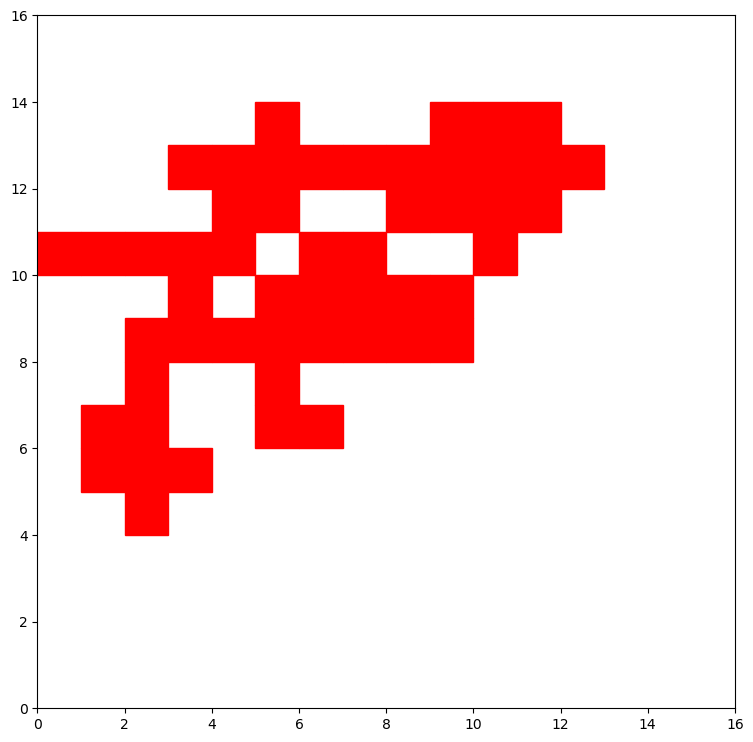

In [111]:
ncluster = np.array([s_a_xy(s, L) for s in cluster])
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(1,1,1)
for x, y in ncluster:
    rect = plt.Rectangle((x, y), 1, 1, color='r', edgecolor='k')
    ax.add_patch(rect)

plt.xlim(0, L)
plt.ylim(0, L)
plt.show()

# 2.

## Funciones

In [125]:
def lineFit(x, y):
    xavg = x.mean()
    slope = (y * (x - xavg)).sum() / (x * (x - xavg)).sum()
    yint = y.mean() - slope * xavg
    return slope, yint

In [126]:
def MassDist2(L, cluster):
    # se convierten los índices lineales del cluster a coordenadas
    cluster_coords = np.array([s_a_xy(s, L) for s in cluster])
    xCluster, yCluster = cluster_coords[:, 0], cluster_coords[:, 1]
    
    # calcula el centro de masa
    xcm = np.mean(xCluster)
    ycm = np.mean(yCluster)
    
    # calcula la distancia radial desde el CM para cada punto del cluster
    dx = xCluster - xcm
    dy = yCluster - ycm
    dr = np.sqrt(dx**2 + dy**2)
    
    # rangos de radio
    r_values = np.arange(1, L//2 + 1)
    mass_dis = np.zeros_like(r_values, dtype=float)
    
    # calcula la masa dentro de cada radio
    for i, r in enumerate(r_values):
        mass_dis[i] = np.sum(dr < r)
        
    return r_values, mass_dis

In [70]:
def IP(L):
    N = L * L
    empty = -1
    nn = boundaries(L, N, empty)  
    site = np.zeros(N, dtype=np.short)
    xseed, yseed = L // 2, L // 2
    sseed = xy_a_s(xseed, yseed, L)
    site[sseed] = 1
    cluster = [sseed]
    randi = np.random.random(N)
    randi[sseed] = -1  

    # invasión percolativa
    while True:
        # determina los vecinos del último sitio añadido
        usite = cluster[-1]
        vecinos = [nn[usite, j] for j in range(4) if nn[usite, j] != empty and site[nn[usite, j]] == 0]

        if not vecinos:
            break  # no hay vecinos disponibles

        # vecino con el valor aleatorio más bajo
        debil = min(vecinos, key=lambda x: randi[x])
        site[debil] = 1
        cluster.append(debil)
        randi[debil] = -1  # Marcar como ocupado

    return cluster

## Método con probabilidad

In [127]:
def IP(L):
    p = 0.59275
    N = L * L
    empty = -1
    nn = boundaries(L, N, empty)  # Utilizamos la función boundaries ya definida para vecinos
    site = np.zeros(N, dtype=np.short)  # Estado del sitio, 0 = vacío, 1 = ocupado, -1 = bloqueado/no usado
    
    # Iniciar en el centro
    xseed, yseed = L // 2, L // 2
    sseed = xy_a_s(xseed, yseed, L)
    site[sseed] = 1
    cluster = np.array([sseed], dtype=int)
    
    # Establecer el perímetro inicial
    per = np.array([nn[sseed, j] for j in range(4) if nn[sseed, j] != empty], dtype=int)
    site[per] = 2  # Marcar el perímetro como activo
    
    # Proceso de invasión percolativa
    while len(per) > 0:
        index = np.random.randint(len(per))
        snew = per[index]
        per = np.delete(per, index)  # Eliminar el sitio seleccionado del perímetro
        
        escPer = np.random.random()
        if escPer < p:
            site[snew] = 1  # Marcar como parte del cluster
            cluster = np.append(cluster, snew)
            # Añadir nuevos vecinos al perímetro
            for j in range(4):
                sper = nn[snew, j]
                if sper != empty and site[sper] == 0:
                    per = np.append(per, sper)
                    site[sper] = 2  # Marcar nuevos sitios perimétricos
        else:
            site[snew] = empty  # Marcar como bloqueado si no percola
    
    return site, cluster


In [128]:
L = 16
p = 0.59275
cluster_ip = IP(L)
site_array = np.zeros((L, L), dtype=np.short)
for idx in cluster_ip:
    x, y = s_a_xy(idx, L)
    site_array[y, x] = 1

site_array

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int16)

In [129]:
def correr(L, realizaciones):  # Probabilidad de percolación ajustada a valor crítico
    massDtot = []
    r = np.arange(1, L//2 + 1)  # Radios

    for _ in range(realizaciones):
        _, cluster = IP(L)  # Asumimos que IP ahora acepta un parámetro de probabilidad p
        _, massD = MassDist2(L, cluster)
        massDtot.append(massD)
        ultCluster = cluster 

    # Promedio de las distribuciones de masa
    massDprom = np.mean(massDtot, axis=0)
    
    return r, massDprom, ultCluster

L = 256: slope = 1.7877302898485228, intercept = 0.689601229907594, error = 5.4110957752104305%, tiempo = 16.92 s


/var/folders/yv/xkr121fn6sg196g8ytf0bq3m0000gn/T/ipykernel_9254/536667641.py:30: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((x, y), 1, 1, color='r', edgecolor='k')


L = 512: slope = 1.7978795691853657, intercept = 0.7268837706818019, error = 4.874096868499163%, tiempo = 72.03 s
L = 1024: slope = 1.8047124989515377, intercept = 0.7132178782890897, error = 4.5125661930403265%, tiempo = 597.37 s


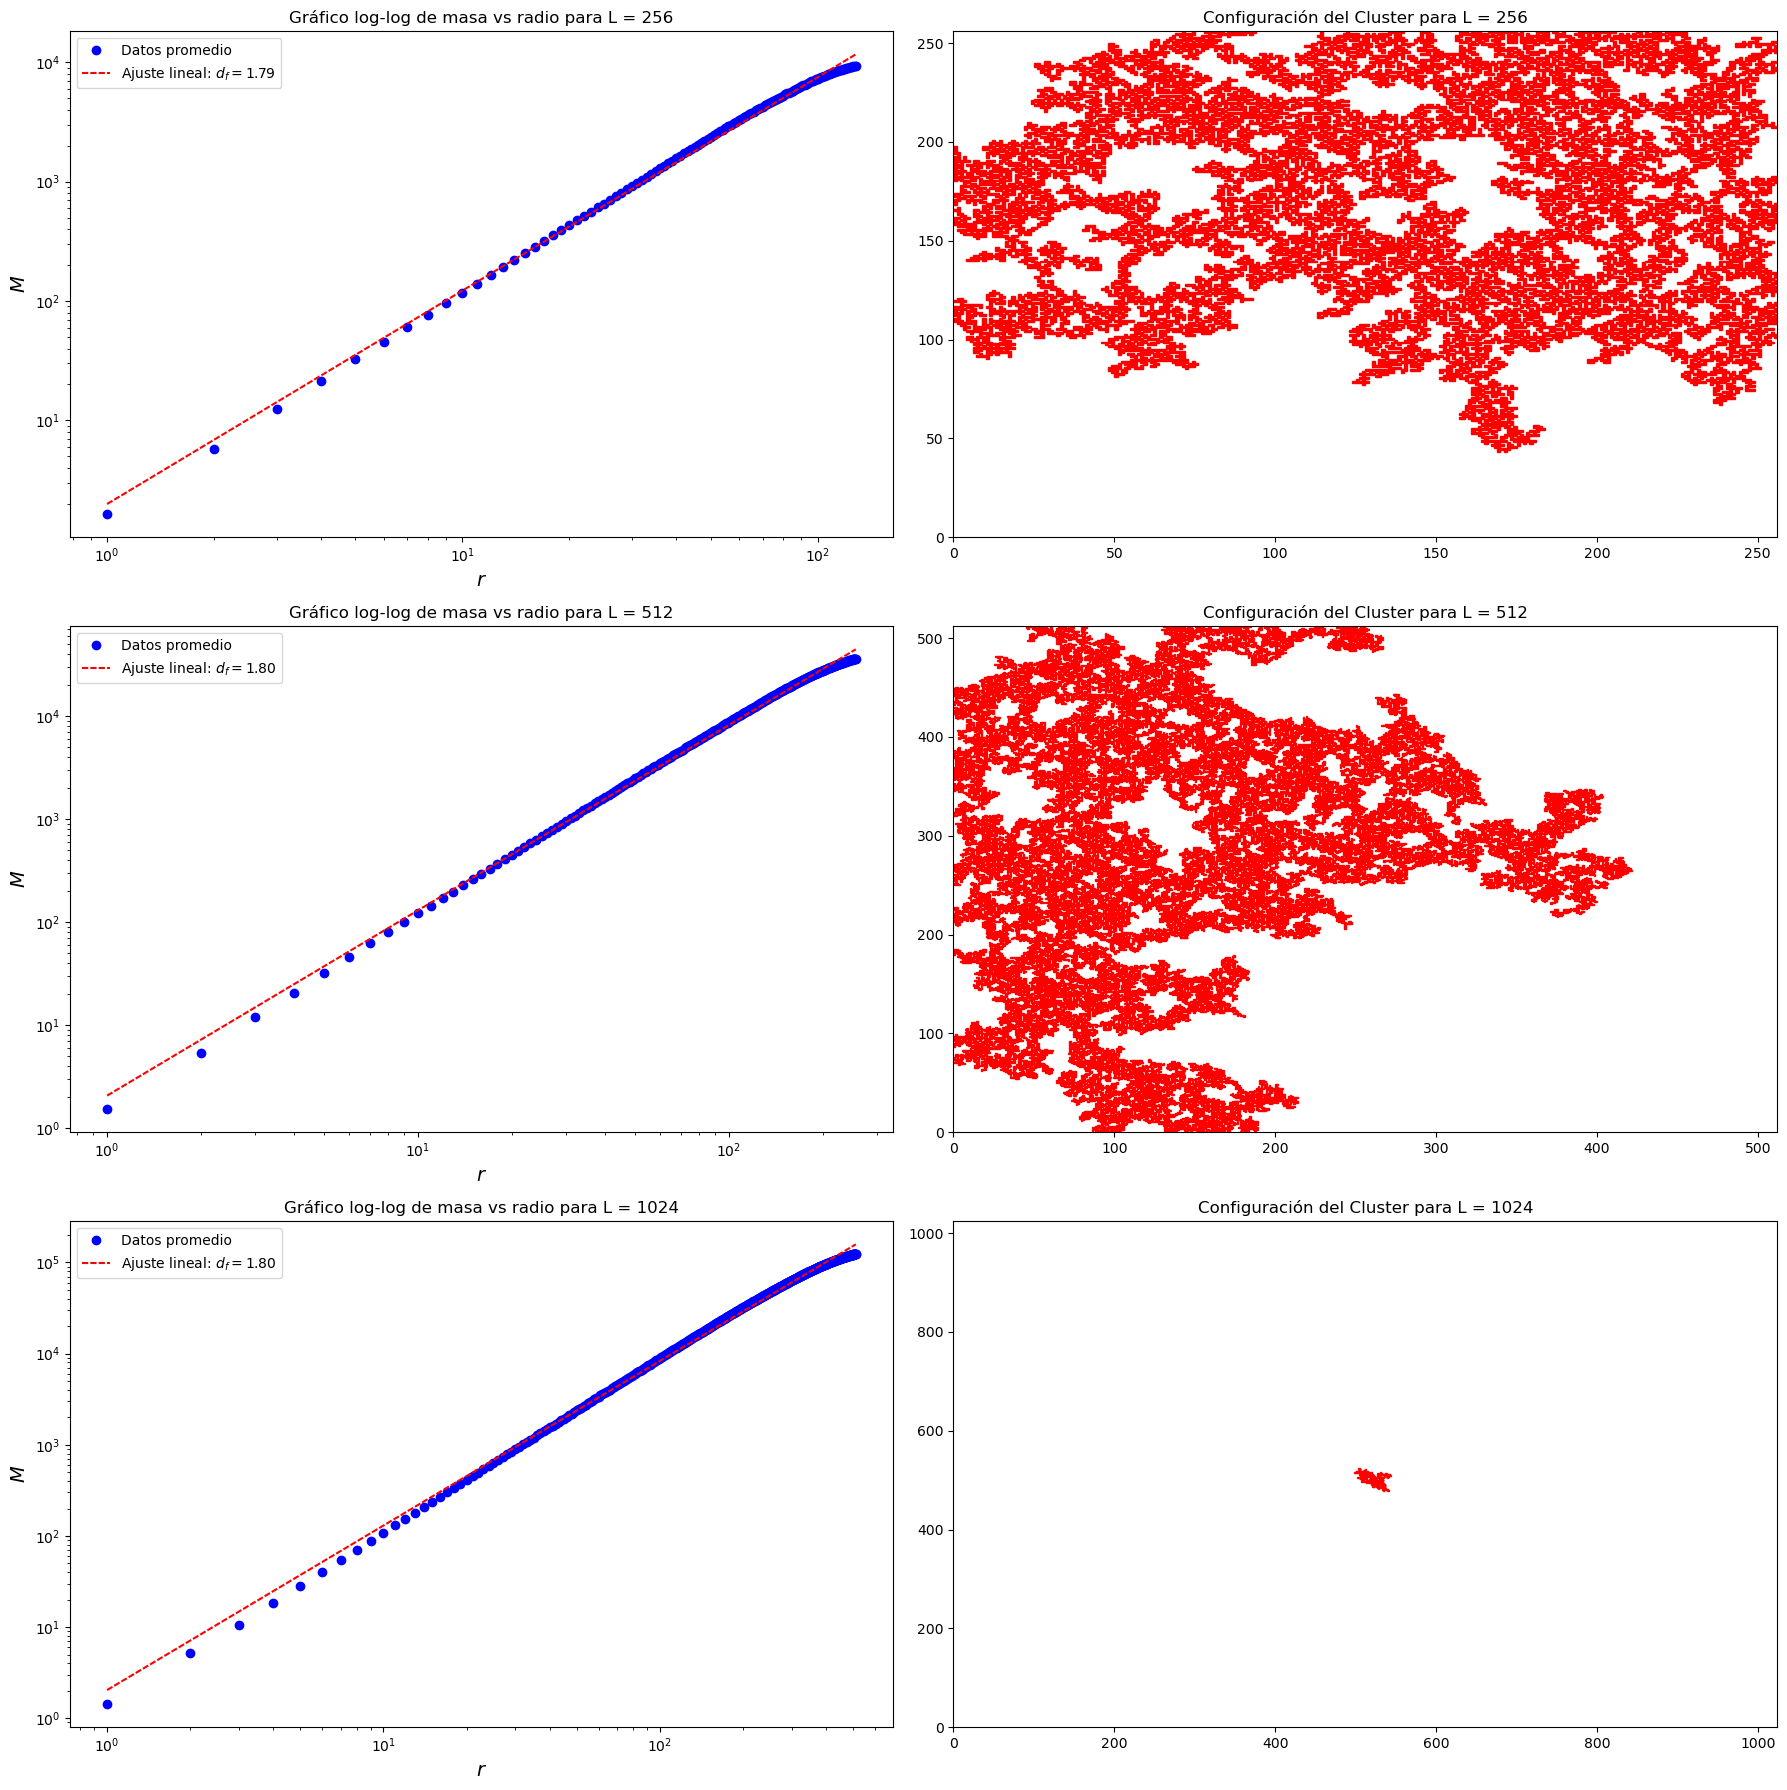

In [121]:
sizes = [256, 512, 1024]
realizaciones = 100
fig, axes = plt.subplots(len(sizes), 2, figsize=(18, 6 * len(sizes)), squeeze=False)

for i, L in enumerate(sizes):
    startTime = time.process_time()
    r, massDprom, cluster = correr(L, realizaciones)  # Genera los datos de masa promedio
    slope, intercept = lineFit(np.log(r), np.log(massDprom))  # Ajuste lineal
    error = np.abs((slope - 1.89) / 1.89) * 100  # Cálculo del error respecto al valor teórico
    endTime = time.process_time()

    print(f"L = {L}: slope = {slope}, intercept = {intercept}, error = {error}%, tiempo = {round(endTime-startTime,2)} s")

    # Preparar los datos para la visualización
    r_exp = np.exp(intercept) * r**slope

    # Gráfico log-log de la distribución de masa
    ax_mass = axes[i][0]
    ax_mass.loglog(r, massDprom, 'bo', label='Datos promedio')
    ax_mass.plot(r, np.exp(intercept) * r**slope, color='red', dashes=(3, 1), label=f'Ajuste lineal: $d_f = {slope:.2f}$')
    ax_mass.set_xlabel(r'$r$', fontsize=14)
    ax_mass.set_ylabel(r'$M$', fontsize=14)
    ax_mass.set_title(f'Gráfico log-log de masa vs radio para L = {L}')
    ax_mass.legend()

    # Visualización de la configuración del cluster
    ncluster = np.array([s_a_xy(s, L) for s in cluster])
    ax_cluster = axes[i][1]
    for x, y in ncluster:
        rect = plt.Rectangle((x, y), 1, 1, facecolor='r', edgecolor='k')
        ax_cluster.add_patch(rect)
    ax_cluster.set_xlim(0, L)
    ax_cluster.set_ylim(0, L)
    ax_cluster.set_title(f'Configuración del Cluster para L = {L}')

plt.tight_layout()
plt.show()

## Método del problema 1

In [137]:
import heapq

En lugar de agregar repetidamente elementos a una lista y ordenarla, lo cual puede volverse extremadamente lento a medida que la lista crece, considera usar una estructura de datos que mantenga un orden eficiente automáticamente. La implementación de un montículo binario (`heapq` en Python) puede ser una buena elección, ya que permite insertar y extraer elementos en tiempo 𝑂(log 𝑛).

In [138]:
def HLA_heapq(L, N, nn, empty):
    site = np.zeros(N, dtype=np.short)
    per = []  # utilizando heap
    
    xseed, yseed = L // 2, L // 2
    sseed = xy_a_s(xseed, yseed, L)
    site[sseed] = 1  
    cluster = [sseed]
    
    for j in range(4):
        sper = nn[sseed, j]
        if sper != empty and site[sper] == 0:
            heapq.heappush(per, (np.random.random(), sper))  # push

    while per:
        _, snew = heapq.heappop(per)
        site[snew] = 1
        cluster.append(snew)
        
        for j in range(4):
            sper = nn[snew, j]
            if sper != empty and site[sper] == 0:
                site[sper] = 2
                heapq.heappush(per, (np.random.random(), sper))  # se mantiene el orden con heap
        
        if snew % L == 0 or snew % L == L-1 or snew // L == 0 or snew // L == L-1:
            break
        
    return cluster

In [139]:
def IP_2(L):
    N = L * L
    empty = -1
    nn = boundaries(L, N, empty)
    return HLA_heapq(L, N, nn, empty)

In [140]:
def correr2(L, num_realizaciones):
    massDtot = []
    r = np.arange(1, L//2 + 1)  # Definir radios

    for _ in range(num_realizaciones):
        cluster = IP_2(L)  # Generar cluster con la función IP
        _, massD = MassDist2(L, cluster)
        massDtot.append(massD)
        ultCluster = cluster 

    # Promedio de las distribuciones de masa
    massDprom = np.mean(massDtot, axis=0)
    
    return r, massDprom, ultCluster

L = 256: slope = 1.5455120545462766, intercept = 1.4281890761478975, error = 18.226875420831924%, tiempo = 4.86 s
L = 512: slope = 1.6045503178456542, intercept = 1.479761785201867, error = 15.103157785944221%, tiempo = 19.6 s
L = 1024: slope = 1.6368348434898903, intercept = 1.4813245541653313, error = 13.394981825931726%, tiempo = 79.58 s


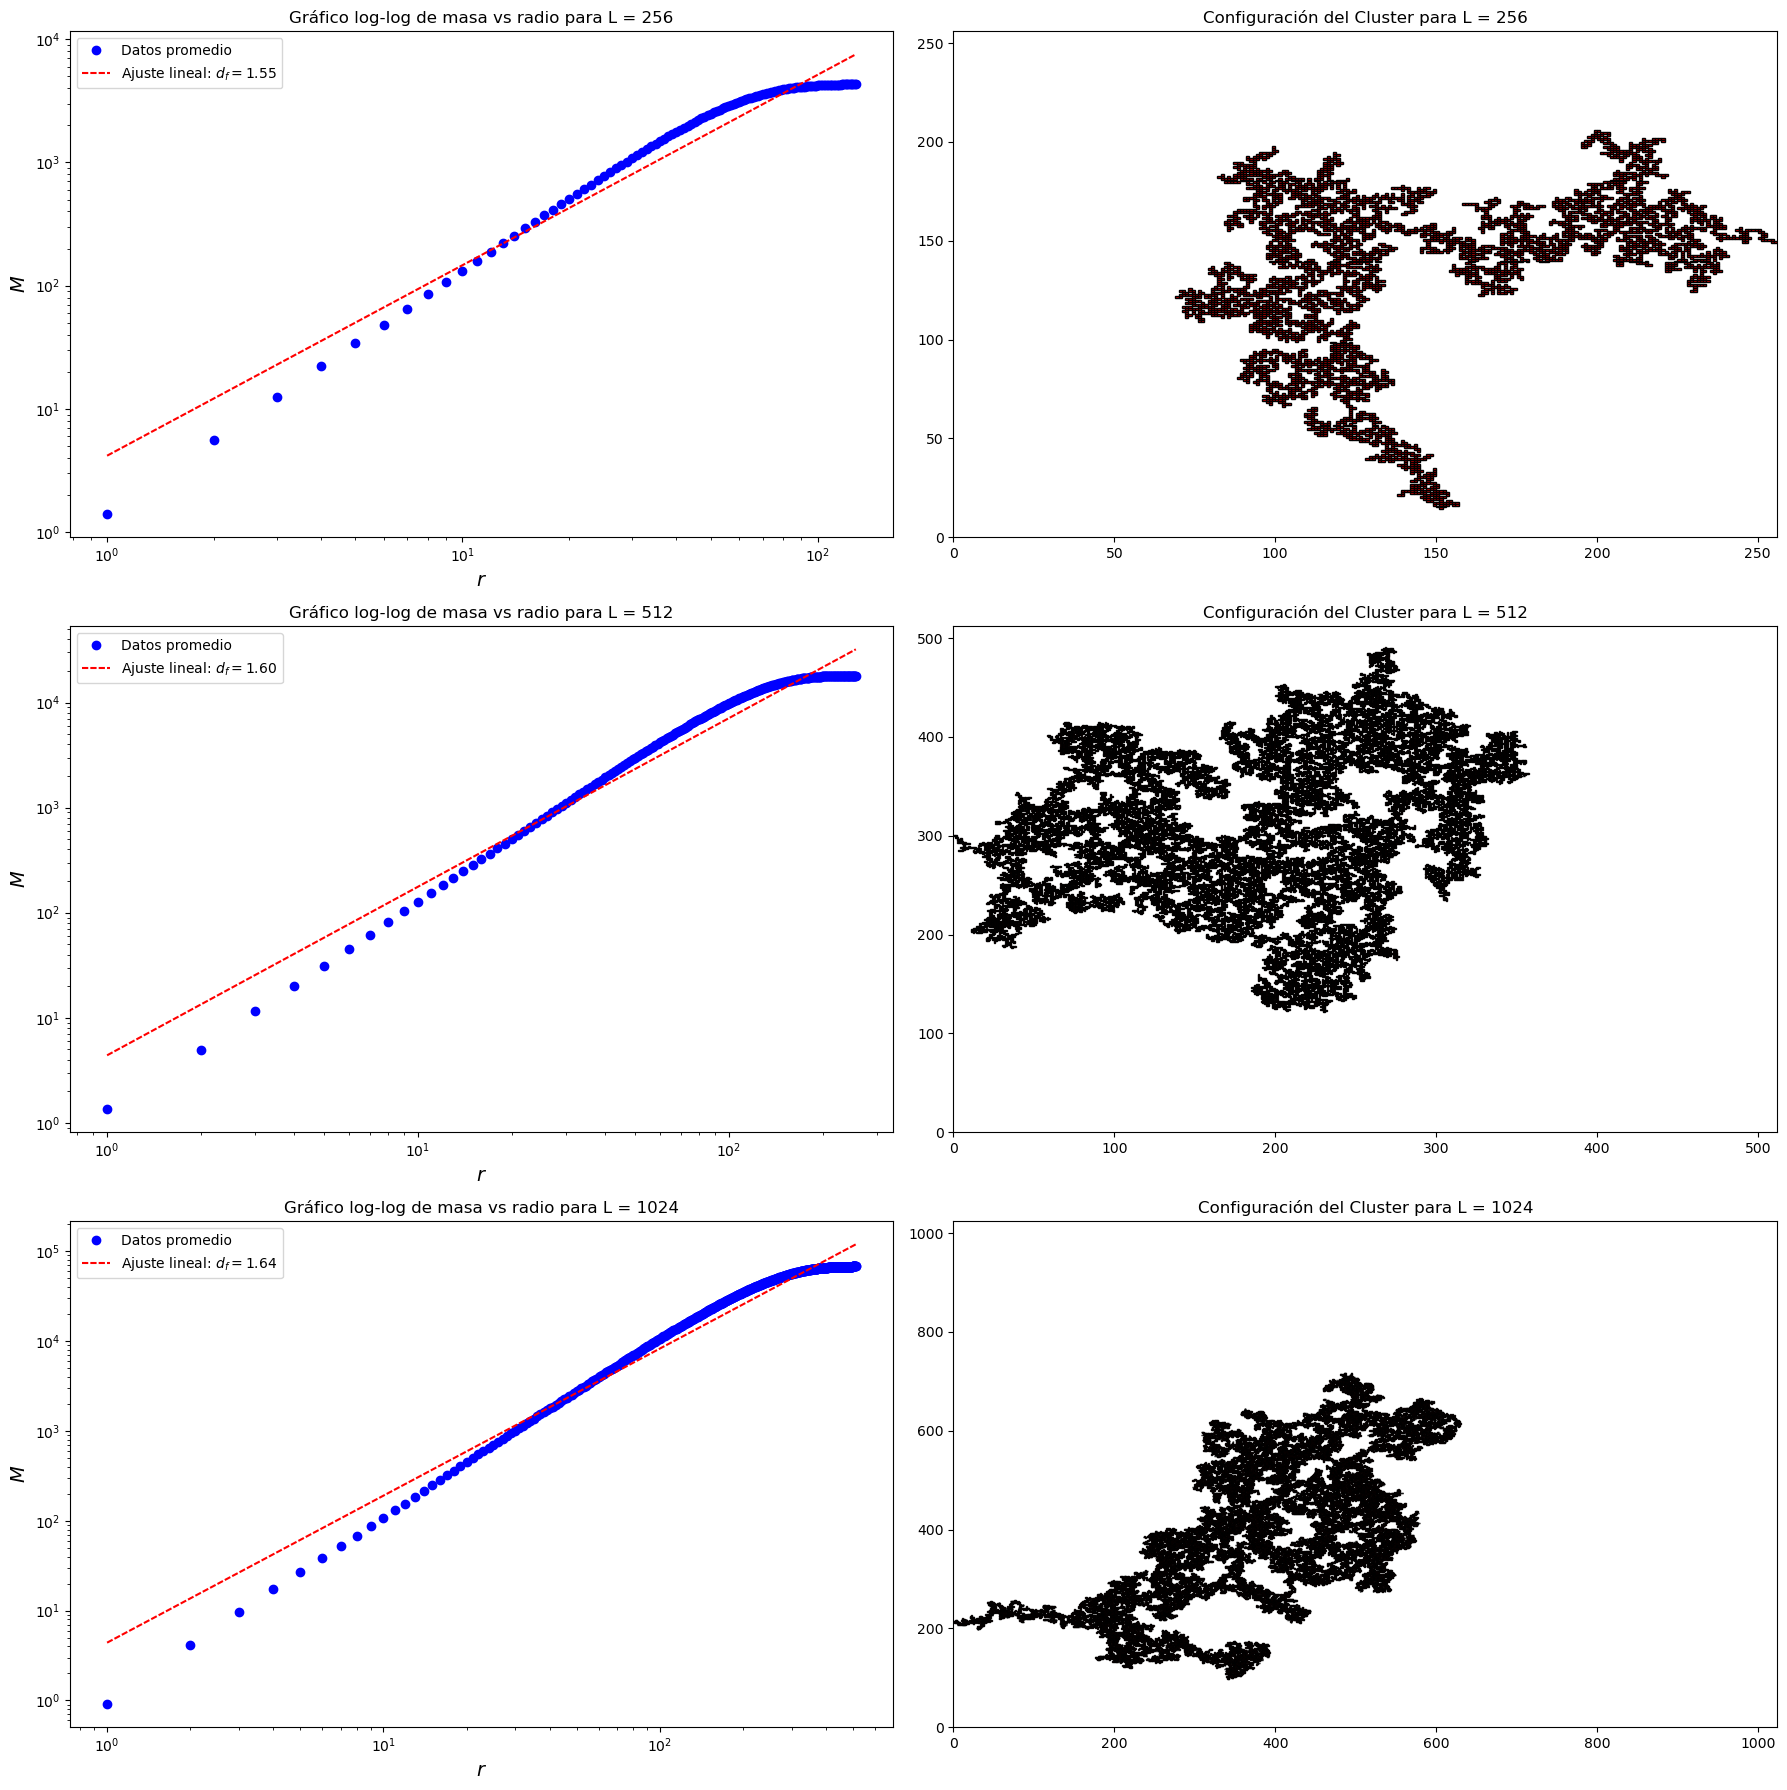

In [141]:
sizes = [256, 512, 1024]
realizaciones = 100
fig, axes = plt.subplots(len(sizes), 2, figsize=(18, 6 * len(sizes)), squeeze=False)

for i, L in enumerate(sizes):
    startTime = time.process_time()
    r, massDprom, cluster = correr2(L, realizaciones)  # Genera los datos de masa promedio
    slope, intercept = lineFit(np.log(r), np.log(massDprom))  # Ajuste lineal
    error = np.abs((slope - 1.89) / 1.89) * 100  # Cálculo del error respecto al valor teórico
    endTime = time.process_time()

    print(f"L = {L}: slope = {slope}, intercept = {intercept}, error = {error}%, tiempo = {round(endTime-startTime,2)} s")

    # Preparar los datos para la visualización
    r_exp = np.exp(intercept) * r**slope

    # Gráfico log-log de la distribución de masa
    ax_mass = axes[i][0]
    ax_mass.loglog(r, massDprom, 'bo', label='Datos promedio')
    ax_mass.plot(r, np.exp(intercept) * r**slope, color='red', dashes=(3, 1), label=f'Ajuste lineal: $d_f = {slope:.2f}$')
    ax_mass.set_xlabel(r'$r$', fontsize=14)
    ax_mass.set_ylabel(r'$M$', fontsize=14)
    ax_mass.set_title(f'Gráfico log-log de masa vs radio para L = {L}')
    ax_mass.legend()

    # Visualización de la configuración del cluster
    ncluster = np.array([s_a_xy(s, L) for s in cluster])
    ax_cluster = axes[i][1]
    for x, y in ncluster:
        rect = plt.Rectangle((x, y), 1, 1, facecolor='r', edgecolor='k')
        ax_cluster.add_patch(rect)
    ax_cluster.set_xlim(0, L)
    ax_cluster.set_ylim(0, L)
    ax_cluster.set_title(f'Configuración del Cluster para L = {L}')

plt.tight_layout()
plt.show()